In [1]:
import pandas as pd
import numpy as np
import os
import sqlalchemy
import pymysql
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

The data from the df below is the basis list of the stocks that I will be using the for built of the traded bot.

In [3]:
df = pd.read_csv("data/SP500Data.csv")

Creation of engine to use mysql in pycharm

In [2]:
url_object = sqlalchemy.URL.create(
    "mysql+pymysql",
    username="root",
    password="luis",  # plain (unescaped) text
    host="localhost",
    database="data",
    )
eng = sqlalchemy.create_engine(url_object)

Method to convert csv to sql.

In [21]:
def convertToSQL(dir = "", filename = ""):
    df = pd.read_csv("%s/%s"%(dir,filename))
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", drop=True, inplace=True) #make sure to convert date to datetime so it can be recognized as such by pandas
    df = df.replace("[^.0-9]", "", regex=True).astype(float) #Here we use some regex to convert all columns to float values
    #Percentage return from previous close day
    df['Returns'] = df['Close'].pct_change(fill_method=None).round(8)
    df = df[df.Returns != 0] #Drop value from day when there was no trade.
    # Calculate weekly returns
    df['Weekly Return'] = ((df['Close'] - df['Close'].shift(7)) / 100).round(8)
    # Calculate monthly returns
    df['Monthly Return'] = ((df['Close'] - df['Close'].shift(30)) / 100).round(8)
    # Calculate the daily price changes
    df['Change'] = df['Close'].diff().round(6)
    # Separate the gains and losses
    df['Gain'] = np.where(df['Change'] > 0, df['Change'], 0).round(6) #if 'Change' > 0 then it is a gain
    df['Loss'] = np.where(df['Change'] < 0, -df['Change'], 0).round(6) #else it is a loss.
    # Calculate the average gains and losses
    df['Avg Gain'] = df['Gain'].rolling(window=14).mean().round(6)
    df['Avg Loss'] = df['Loss'].rolling(window=14).mean().round(6)
    # Calculate the Relative Strength (RS)
    df['RS'] = (df['Avg Gain'] / df['Avg Loss']).round(6)
    # Calculate the RSI
    df['RSI'] = (100 - (100 / (1 + df['RS']))).round(6)
    # Calculate the Simple Moving Average with a span of 5 days
    df['MA5'] = df['Close'].rolling(window=5).mean().round(6)
    # Calculate the Simple Moving Average with a span of 10 days
    df['MA10'] = df['Close'].rolling(window=10).mean().round(6)
    # Calculate the Simple Moving Average with a span of 20 days
    df['MA20'] = df['Close'].rolling(window=20).mean().round(6)
    # Calculate the Simple Moving Average with a span of 50 days
    df['MA50'] = df['Close'].rolling(window=50).mean().round(6)
    # Calculate the Simple Moving Average with a span of 200 days
    df['MA200'] = df['Close'].rolling(window=200).mean().round(6)
    # Calculate the EWMA with a span of 10 days
    df['EWMA10'] = df['Close'].ewm(span=10, adjust=False).mean().round(6)
    # Calculate the EWMA with a span of 12 days for MACD
    df['EWMA12'] = df['Close'].ewm(span=12, adjust=False).mean().round(6)
    # Calculate the EWMA with a span of 26 days for MACD
    df['EWMA26'] = df['Close'].ewm(span=26, adjust=False).mean().round(6)
    # Calculate the EWMA with a span of 50 days
    df['EWMA50'] = df['Close'].ewm(span=50, adjust=False).mean().round(6)
    # Calculate the EWMA with a span of 200 days
    df['EWMA200'] = df['Close'].ewm(span=200, adjust=False).mean().round(6)
    # Calculate the 20-day rolling volatility (standard deviation of returns)
    df['Volatility20'] = df['Returns'].rolling(window=20).std().round(6)
    # Calculate the 30-day rolling volatility
    df['Volatility30'] = df['Returns'].rolling(window=30).std().round(6)
    # Calculate the MACD line
    df['MACD'] = (df['EWMA12'] - df['EWMA26']).round(6)
    # Calculate the Signal line (9 periods EMA of the MACD line)
    df['Signal Line'] = (df['MACD'].ewm(span=9, adjust=False).mean()).round(6)
    # Calculate the MACD Histogram
    df['MACD Histogram'] = (df['MACD'] - df['Signal Line']).round(6)
    #Calculate Standard Dev for 20MA
    df["STD20"] = (df['Close'].rolling(window=20).std()).round(6)
    # Calculate the Upper and Lower Bollinger Bands
    df['Upper Band'] = (df['MA20'] + (2 * df['STD20'])).round(6)
    df['Lower Band'] = (df['MA20'] - (2 * df['STD20'])).round(6)
    # Calculate the typical price
    df['Typical Price'] = ((df['High'] + df['Low'] + df['Close']) / 3).round(6)
    # Calculate the cumulative typical price * volume
    df['Cumulative TPV'] = ((df['Typical Price'] * df['Volume']).cumsum()).round(6)
    # Calculate the cumulative volume
    df['Cumulative Volume'] = (df['Volume'].cumsum()).round(6)
    # Calculate the VWAP
    df['VWAP'] = (df['Cumulative TPV'] / df['Cumulative Volume']).round(6)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(how='any', inplace=True)
    #price rises next day then buy, if not then 0 and we sell
    df['Buy'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    filename = (filename[:-4]).lower()
    df.to_sql(name="%s"%filename, con=eng, if_exists="replace", index=True)

In [19]:
def formPreds(X, y, model, t_s=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_s, shuffle=False)
    model.fit(X_train, y_train.values.ravel())
    preds = model.predict_proba(X_test)[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=y_test.index, name='predictions', dtype='int')
    combined = pd.concat([y_test, preds], axis=1)
    return combined

In [20]:
def backTest(df, model, predictors):
    X = df[predictors[0:-1]]
    y = df[predictors[-1]]
    preds = formPreds(X,y,model)
    prec = precision_score(preds['Buy'], preds['predictions'])
    return preds, prec

In [48]:
df = pd.DataFrame
dir = 'data/SP500Data'
directory = os.fsencode(dir)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    convertToSQL(dir, filename)
    break

ML models such as RFC are limited to learning only from one table, they obtain the best fit line quickly but I am not sure if this is the best way to form predictions.

In [42]:
model = RandomForestClassifier(n_estimators=50, min_samples_split=50, random_state=1)

In [43]:
parameters = {
    'min_samples_split' : [5, 25, 50, 100],
    'n_estimators' : [10,50,100,200]
}

In [44]:
classifier = GridSearchCV(model, parameters, cv=5)

In [45]:
z = 0
dfOne = pd.read_sql('SELECT MA5, MA20, RSI, MACD, `Signal Line`, Buy FROM `a`', con=eng)
df = pd.DataFrame
directory = os.fsencode('data/SP500Data')
for file in os.listdir(directory):
    z+=1
    if z == 1:
        continue
    if z > 2:
        break
    filename = os.fsdecode(file)
    filename = (filename[:-4]).lower()
    df = pd.read_sql('SELECT MA5, MA20, RSI, MACD, `Signal Line`, Buy FROM `%s`'%filename, con=eng)
    dfOne = pd.concat([df, dfOne], axis=0)

In [10]:
X = dfOne[dfOne.columns[:-1]].copy()
y = dfOne[dfOne.columns[-1]].copy()
classifier.fit(X, y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(min_samples_split=50,
                                              n_estimators=200,
                                              random_state=1),
             param_grid={'min_samples_split': [5, 25, 50, 100],
                         'n_estimators': [10, 50, 100, 200]})

In [13]:
classResults = pd.DataFrame(classifier.cv_results_)
classResults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.436049,0.040047,0.004855,0.006360,5,10,"{'min_samples_split': 5, 'n_estimators': 10}",0.494160,0.486219,0.500599,0.501198,0.520072,0.500450,0.011204,13
1,2.100621,0.090309,0.018421,0.006440,5,50,"{'min_samples_split': 5, 'n_estimators': 50}",0.492363,0.493709,0.503295,0.503895,0.522169,0.503086,0.010656,9
2,4.128491,0.177201,0.034467,0.011804,5,100,"{'min_samples_split': 5, 'n_estimators': 100}",0.492363,0.494008,0.502397,0.492211,0.517675,0.499731,0.009723,15
3,8.149659,0.254122,0.056662,0.021397,5,200,"{'min_samples_split': 5, 'n_estimators': 200}",0.492063,0.487418,0.503595,0.505992,0.527861,0.503386,0.014064,8
4,0.378717,0.021072,0.000000,0.000000,25,10,"{'min_samples_split': 25, 'n_estimators': 10}",0.495957,0.488916,0.494008,0.504494,0.501198,0.496915,0.005462,16
5,1.871863,0.075169,0.012510,0.006255,25,50,"{'min_samples_split': 25, 'n_estimators': 50}",0.494160,0.490713,0.494907,0.522469,0.508987,0.502247,0.011888,10
6,3.710339,0.157943,0.021986,0.012585,25,100,"{'min_samples_split': 25, 'n_estimators': 100}",0.490866,0.490114,0.491013,0.518274,0.518874,0.501828,0.013678,11
7,7.415701,0.257088,0.051390,0.018703,25,200,"{'min_samples_split': 25, 'n_estimators': 200}",0.501647,0.488616,0.492211,0.512882,0.525165,0.504104,0.013476,7
8,0.356683,0.018055,0.006249,0.007653,50,10,"{'min_samples_split': 50, 'n_estimators': 10}",0.503744,0.481126,0.502696,0.506890,0.504793,0.499850,0.009464,14
9,1.780970,0.036599,0.012508,0.006254,50,50,"{'min_samples_split': 50, 'n_estimators': 50}",0.504642,0.488616,0.502696,0.516177,0.520072,0.506441,0.011096,1


In [29]:
best_par = classifier.best_params_
print(best_params)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [46]:
predictors = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal Line', 'Buy']
preds, prec = backTest(dfOne,model,predictors)

In [47]:
print(preds['Buy'].value_counts() / preds.shape[0]) #actual number of days it went up
print(prec) #number of times we decided to buy and it actually went up.
print(prec - (preds['Buy'].value_counts() / preds.shape[0])[1]) # The more positive the better

Buy
1    0.528166
0    0.471834
Name: count, dtype: float64
0.5434782608695652
0.015312322004936374


We did 1.53% percent better by using the model in a & apple than if they worked by themselves.

In [17]:
dfOne.describe()

,MA5,MA20,RSI,MACD,Signal Line,Buy
count,633164.000000,633164.000000,633164.000000,633164.000000,633164.000000,633164.000000
mean,79.249853,79.002766,52.554746,0.229576,0.229073,0.515252
std,190.743716,189.557274,16.319094,3.999902,3.735563,0.499768
min,0.014000,0.022000,0.000000,-176.716866,-152.094959,0.000000
25%,17.020000,16.974875,41.042316,-0.236596,-0.217687,0.000000
50%,38.042000,37.974500,52.755455,0.085295,0.084977,1.000000
75%,75.934000,75.768625,64.275485,0.566709,0.543283,1.000000
max,5254.020000,5191.591500,99.894779,218.653958,195.227185,1.000000


In [10]:
df = pd.read_sql('SELECT MA5, MA20, RSI, MACD, `Signal Line`, Buy FROM `a`', con=eng)
features = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal Line']
X_test = df[features]
target = ['Buy']
y_test = df[target]
y_pred = model.predict_proba(X_test)[:,1]
y_pred[y_pred >= 0.6] = 1
y_pred[y_pred < 0.6] = 0
prec = precision_score(y_test, y_pred)
print("aapl" , prec)

aapl 0.6843177189409368


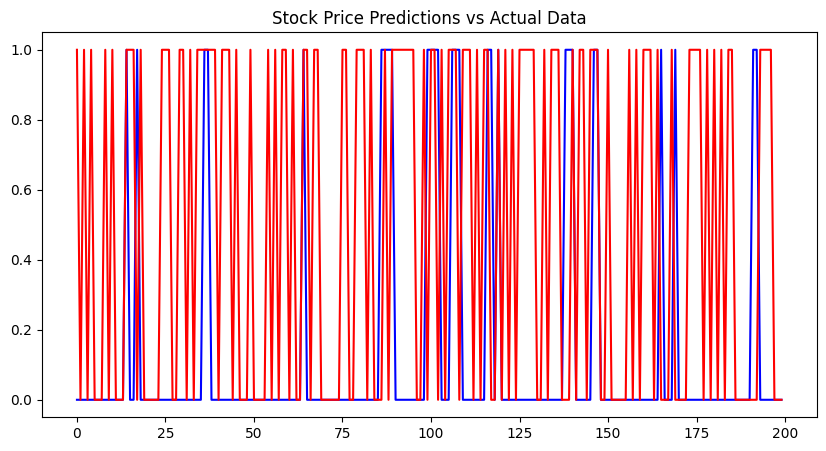

In [11]:
k = 200
plt.figure(figsize=(10,5))
plt.plot(range(k), preds['predictions'][-k:], label='predictions', color='blue')
plt.plot(range(k), preds['Buy'][-k:], label='actual', color='red')
plt.title('Stock Price Predictions vs Actual Data')
plt.show()

Model RandomForestRegressor using MA5, MA20, RSI to get closing price. Not Good because it forgets each time it fits.